In [9]:
import catboost as cb
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, ParameterGrid
from sklearn.metrics import accuracy_score,confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
data = pd.read_csv('MIL_101_Cr_data.csv')
data.head()


,Nucleating agent,n_nucleat,n_GdmCl,v_H2O,temperature,Label
0,none,0.0,0,4.8,220,MIL-101
1,none,0.0,0,4.8,218,MIL-101
2,NaOH,1.0,0,5.0,220,MIL-101
3,none,0.0,0,5.0,200,MIL-101
4,none,0.0,0,5.0,180,MIL-101


In [11]:
X = data.drop(['Label'], axis=1)
y = data.loc[:, 'Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = CatBoostClassifier()

cat_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

param_grid = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.1, 0.15],
    'depth': [2,4, 6, 8],
    'l2_leaf_reg': [3, 5, 7]
}

grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train, cat_features=cat_features, eval_set=(X_test, y_test), verbose=False)

best_params = grid_search.best_params_

best_model = CatBoostClassifier(**best_params)
best_model.fit(X_train, y_train, cat_features=cat_features, eval_set=(X_test, y_test), verbose=False)

y_predict_train = best_model.predict(X_train)
y_predict_test = best_model.predict(X_test)

accuracy_train = accuracy_score(y_train, y_predict_train)
accuracy_test = accuracy_score(y_test, y_predict_test)

print("Best parameters found: ", best_params)
print("accuracy_train:", accuracy_train)
print("accuracy_test:", accuracy_test)




Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters found:  {'depth': 4, 'iterations': 200, 'l2_leaf_reg': 7, 'learning_rate': 0.1}
accuracy_train: 0.9619047619047619
accuracy_test: 0.8518518518518519


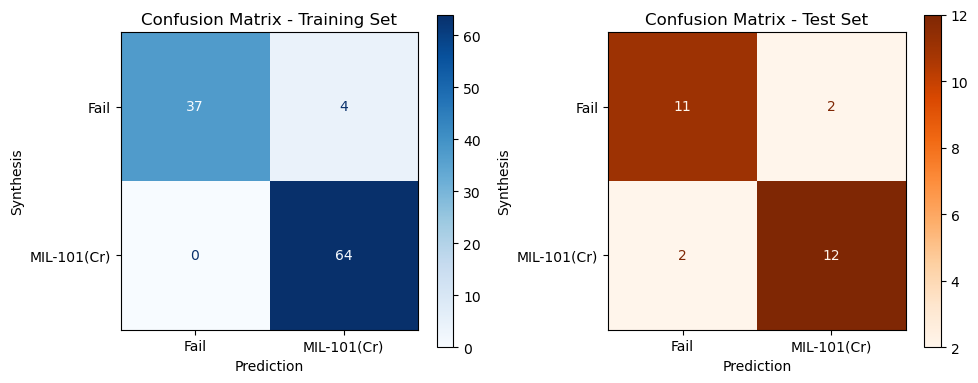

In [13]:
conf_matrix_train = confusion_matrix(y_train, y_predict_train)
conf_matrix_test = confusion_matrix(y_test, y_predict_test)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

disp_train = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_train, display_labels=['Fail', 'MIL-101(Cr)'])
disp_train.plot(cmap=plt.cm.Blues, ax=ax[0])
ax[0].set_title('Confusion Matrix - Training Set')
ax[0].set_xlabel('Prediction')
ax[0].set_ylabel('Synthesis')

disp_test = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_test, display_labels=['Fail', 'MIL-101(Cr)'])
disp_test.plot(cmap=plt.cm.Oranges, ax=ax[1])
ax[1].set_title('Confusion Matrix - Test Set')
ax[1].set_xlabel('Prediction')
ax[1].set_ylabel('Synthesis')

plt.tight_layout()

plt.savefig('confusion_matrices_CatBoost.png')

plt.show()



In [14]:
import joblib

model = best_model 
model_path = 'CatBoost_model.joblib'
joblib.dump(model, model_path)


['CatBoost_model.joblib']